In [23]:
import pprint
import numpy as np
import pandas as pd
import scipy.linalg as sl
from sklearn.linear_model import LinearRegression
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pylab as plt
import scipy.sparse as sparse
import time
import math

## Problem 1

#### 1.1 Read the data and include an intercept in your model

In [24]:
# Read the data by using pandas
longley = pd.read_csv("longley.dat", header=None, delim_whitespace=True)

In [25]:
# Rename the column 
longley.rename(columns={0:"number of people employed", 1:"GNP implicit price deflator", 2: "GNP", 3:"number of unemployed",
4: "number of people in the armed forces", 5: "noninst. pop", 6: "year"}, inplace=True)

longley.head()


,number of people employed,GNP implicit price deflator,GNP,number of unemployed,number of people in the armed forces,noninst. pop,year
0,60323,83.0,234289,2356,1590,107608,1947
1,61122,88.5,259426,2325,1456,108632,1948
2,60171,88.2,258054,3682,1616,109773,1949
3,61187,89.5,284599,3351,1650,110929,1950
4,63221,96.2,328975,2099,3099,112075,1951


In [26]:
lm = LinearRegression()

Y = longley.iloc[:,0:1]
X = longley.iloc[:,1:]

model = lm.fit(X, Y)


print(model.coef_)
print(model.intercept_)



[[ 1.50618723e+01 -3.58191793e-02 -2.02022980e+00 -1.03322687e+00
  -5.11041057e-02  1.82915146e+03]]
[-3482258.63459582]


### 1.2

#### LU decomposition

In [27]:
# make array of A and b from the data
A = longley.iloc[:,1:]
b = longley.iloc[:,0:1]

A = np.array(A)

# add column of one for intercept
ncol = np.array(np.repeat(1, len(A)))
ncol = ncol.reshape(-1,1)
# ncol.shape

An = np.append(A, ncol, axis=1)

An = An[:, [6,0,1,2,3,4,5]]




print(np.array_str(An, precision=1, suppress_small=True))



[[     1.      83.  234289.    2356.    1590.  107608.    1947. ]
 [     1.      88.5 259426.    2325.    1456.  108632.    1948. ]
 [     1.      88.2 258054.    3682.    1616.  109773.    1949. ]
 [     1.      89.5 284599.    3351.    1650.  110929.    1950. ]
 [     1.      96.2 328975.    2099.    3099.  112075.    1951. ]
 [     1.      98.1 346999.    1932.    3594.  113270.    1952. ]
 [     1.      99.  365385.    1870.    3547.  115094.    1953. ]
 [     1.     100.  363112.    3578.    3350.  116219.    1954. ]
 [     1.     101.2 397469.    2904.    3048.  117388.    1955. ]
 [     1.     104.6 419180.    2822.    2857.  118734.    1956. ]
 [     1.     108.4 442769.    2936.    2798.  120445.    1957. ]
 [     1.     110.8 444546.    4681.    2637.  121950.    1958. ]
 [     1.     112.6 482704.    3813.    2552.  123366.    1959. ]
 [     1.     114.2 502601.    3931.    2514.  125368.    1960. ]
 [     1.     115.7 518173.    4806.    2572.  127852.    1961. ]
 [     1. 

In [28]:



def forward_substitution(L, b):
    
    #Get number of rows
    n = L.shape[0]
    
    #Allocating space for the solution vector
    y = np.zeros_like(b, dtype=np.double);
    
    #Here we perform the forward-substitution.  
    #Initializing  with the first row.
    y[0] = b[0] / L[0, 0]
    
    #Looping over rows in reverse (from the bottom  up),
    #starting with the second to last row, because  the 
    #last row solve was completed in the last step.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        
    return y



def back_substitution(U, y):
    
    #Number of rows
    n = U.shape[0]
    
    #Allocating space for the solution vector
    x = np.zeros_like(y, dtype=np.double);

    #Here we perform the back-substitution.  
    #Initializing with the last row.
    x[-1] = y[-1] / U[-1, -1]
    
    #Looping over rows in reverse (from the bottom up), 
    #starting with the second to last row, because the 
    #last row solve was completed in the last step.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
        
    return x


In [29]:
# X' * X
Asq = np.dot(np.transpose(An),An)

# Compute LU decomposition
P, L, U = sl.lu(Asq)



In [30]:
# X' * b
B = np.dot(An.T, b)

# P' * yhat (pivoting)
Y = np.dot(P.T, B)


In [31]:
# Compute forward subsitution for L(Ub) = P'* yhat
Ub = forward_substitution(L, Y)

# find a coefficient by backward substitution
betahat = back_substitution(U, Ub)

print("The regression coefficient betahat is : ")
print(betahat[1:])
print("The intercept is :")
print(betahat[0])

The regression coefficient betahat is : 
[[ 1.50618724e+01]
 [-3.58191794e-02]
 [-2.02022981e+00]
 [-1.03322687e+00]
 [-5.11041052e-02]
 [ 1.82915147e+03]]
The intercept is :
[-3482258.63651315]


In [32]:
print(model.coef_, model.intercept_)

[[ 1.50618723e+01 -3.58191793e-02 -2.02022980e+00 -1.03322687e+00
  -5.11041057e-02  1.82915146e+03]] [-3482258.63459582]


In [33]:
# check if they have the same value
np.allclose(betahat[1:], np.array(model.coef_).reshape(-1,1))

True

When we compare the coefficient and intercept by using **sklearn Linear Regression function** and by **LU decomposition**, we can check that their results are same. 

In [34]:
def sterror(data):
    return np.std(data, ddof=1) / np.sqrt(np.size(data))


In [35]:

sterror(betahat[1:]), np.var(betahat[1:])
print(f"[LU decomposition] The standard error is {sterror(betahat[1:])} and the variance is {np.var(betahat[1:])}")


[LU decomposition] The standard error is 304.4723390469291 and the variance is 463517.0262235407


#### Cholesky decomposition

In [36]:
# Compute cholesky factor first
c, low = cho_factor(Asq)

# Then compute betahat by using cho_solve function
xhat = cho_solve((c, low), B)
xhat

array([[-3.48225863e+06],
       [ 1.50618723e+01],
       [-3.58191793e-02],
       [-2.02022980e+00],
       [-1.03322687e+00],
       [-5.11041056e-02],
       [ 1.82915146e+03]])

In [37]:
print("The regression coefficient betahat is : ")
print(xhat[1:])
print("The intercept is :")
print(xhat[0])

The regression coefficient betahat is : 
[[ 1.50618723e+01]
 [-3.58191793e-02]
 [-2.02022980e+00]
 [-1.03322687e+00]
 [-5.11041056e-02]
 [ 1.82915146e+03]]
The intercept is :
[-3482258.63473125]


In [38]:
# check if they have the same value
np.allclose(xhat[1:], np.array(model.coef_).reshape(-1,1))

True

We can see that **cholesky decomposition** gives us the same result for intercept and coefficients as we computed by using **sklearn linear regression function**.

In [39]:
sterror(betahat[1:]), np.var(betahat[1:])
print(f"[Cholesky decomposition] The standard error is {sterror(xhat[1:])} and the variance is {np.var(xhat[1:])}")

[Cholesky decomposition] The standard error is 304.47233889966105 and the variance is 463517.02577515034


QR decomposition

In [40]:
q, r = sl.qr(An)

In [41]:
p = np.dot(q.T, np.array(b))
xhat_qr = np.dot(np.linalg.pinv(r), p)

In [42]:
# check if they have the same value
np.allclose(xhat_qr[1:], np.array(model.coef_).reshape(-1,1))

True

We can see that **QR decomposition** gives us the same result for intercept and coefficients as we computed by using **sklearn linear regression function**.

In [43]:
sterror(xhat_qr[1:]), np.var(xhat_qr[1:])
print(f"[QR decomposition] The standard error is {sterror(xhat[1:])} and the variance is {np.var(xhat[1:])}")

[QR decomposition] The standard error is 304.47233889966105 and the variance is 463517.02577515034


## 1.3

## 1.4

## 1.5

# Problem 2

## 2.1

In [44]:
# Read data of csv file. 
A = pd.read_csv("A.txt", sep=',', header=None)
U = pd.read_csv("U.txt", header=None)

U


,0
0,https://ucdavis.edu/
1,http:/
2,http://my.ucdavis.edu
3,http://campusmap.ucdavis.edu
4,http://www.ucdavisaggies.com
...,...
495,http://t.co/IxO8OCg472
496,http://www.pepsi.com
497,http://www.sportstravelhawaii.com
498,http://www.islandmovers.com


In [45]:
At = np.array(A.T)


#### (a) number of pages

In [46]:
# length of url
print(f"The number of pages are {len(U)}.")

The number of pages are 500.


#### (b) number of edges (page links)

In [47]:
# count all the 1's in A
print(f"The number of edges (page links) is {np.sum(At)}.")

The number of edges (page links) is 2958.


#### (c) number of dangling nodes

In [48]:
cnt = 0

# count pages that does not linked to the outward link 
for i in range(500):
    if np.sum(At[i,]) == 0:
        cnt +=1

print(f"The number of dangling nodes is : {cnt}.")

The number of dangling nodes is : 200.


#### (d) max in-degree

In [49]:
# max column sum 

Maxindeg = max(A.T.sum(axis=0))

print(f"The max in-degree is : {Maxindeg}.")

The max in-degree is : 80.


#### (e) max out-degree

In [50]:
# max row sum

Maxoutdeg = max(A.T.sum(axis=1))

print(f"The max out-degree is : {Maxoutdeg}.")

The max out-degree is : 51.


#### (f) visualize sparsity pattern of A

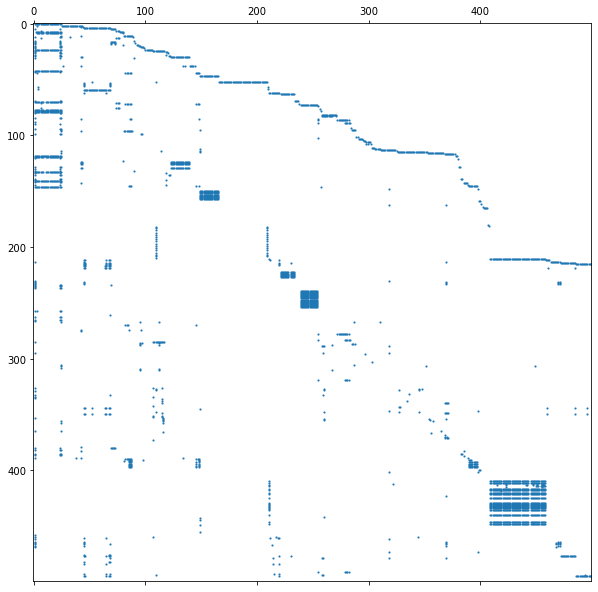

In [51]:
# use pyplot.spy function 

plt.figure(figsize=(10,16))
plt.spy(At,markersize=1)
plt.show();


## 2.2

In [52]:
# Prepare the data 

# create a row with 500's 1. 
newrow = np.array(np.repeat(1, len(At)))

# add to the raw data 
Atn = np.vstack([newrow, At])

# create b with 500's 0
b = np.array(np.repeat(0, len(At)))

# reshape to (500,1)
b = b.reshape(-1, 1)
# b.shape

# append 1 on the top
bnewrow = np.array(1)
bn = np.vstack([bnewrow, b])


# sparseAt =  sparse.csr_matrix(At)



#### (a) Dense linear system sover : LU decomposition

In [53]:
start = time.time() 

P, L, U = sl.lu(At)










end = time.time() 


print(f"{end - start:.5f} sec")



0.01995 sec


In [54]:
lm = LinearRegression()

model = lm.fit(Atn, bn)


print(model.coef_)
print(model.intercept_)

[[ 1.15478592e-01  5.55111512e-17 -5.30825384e-16 -5.55111512e-17
  -5.35044841e-02  9.56080616e-03 -7.99532284e-02  8.72522610e-03
   9.52051031e-03 -3.72656842e-04  3.72656842e-04  8.96376703e-03
   8.39644909e-03  8.94833228e-03  8.79539225e-03  8.88996840e-03
   9.06206550e-03  8.62545444e-03  8.53512743e-03  8.84599132e-03
   8.85052483e-03  8.81916578e-03  8.91893159e-03  1.90819582e-16
   3.55618313e-17  1.20848309e-02 -6.81950707e-02  1.21014794e-02
   1.21277812e-02  1.21928827e-02  1.22349748e-02  1.24904020e-02
  -5.17338722e-02  1.20595619e-02  1.21200689e-02  1.22390290e-02
   1.21003930e-02  1.21815226e-02  3.97354836e-02  1.20780618e-02
   1.21578804e-02  1.21752516e-02 -5.81132364e-17 -9.01506610e-02
  -8.45677695e-16 -3.19189120e-16 -1.70002901e-16  4.68861867e-03
   4.76364737e-03  4.66751651e-03  4.67848257e-03  4.63211563e-03
  -7.98306878e-02  4.73869988e-03  4.64119753e-03  4.68919240e-03
   4.77254215e-03  4.77040715e-03  4.66146720e-03  4.68197480e-03
   4.68131

In [55]:
print(len(model.coef_))

1
